In [1]:
import dolfin
import fenics

In [2]:
import pyurdme

In [3]:
from pyurdme import microsolver

In [4]:
import math
import numpy
import time
import matplotlib.pyplot as plt

In [5]:
import mshr

In [6]:
%matplotlib inline

In [7]:
def hhp_kr(h,kr,D,sigma,dim):
    if(dim==3):
        kr_kc = 4.0*math.pi*sigma*D*kr/(4.0*math.pi*sigma*D+kr)
        tau_diff = 1.5164/(6*D*h)
        tau_eff = 1.0/kr_kc

    return 1.0/(tau_eff-tau_diff);

def hhp_kd(h,kr,kd,D,sigma,dim):

    kr_hhp = hhp_kr(h,kr,D,sigma,dim)
    return pow(h,dim)*kd*kr_hhp/kr

In [153]:
class Example2(pyurdme.URDMEModel):
    """ The reversible reaction A+B<->C in 2D.  """
    
    def __init__(self,kr):
        
        pyurdme.URDMEModel.__init__(self,name="reversible")

        
        #Parameters (normalized s.t. V=1)
        V = 0.5005
        D = 1.0
        sigma = 2.5e-3
        k1 = 10
        k2 = kr
        
        
        
        

        # Substrate and enzymes
        S1 = pyurdme.Species(name="S1",reaction_radius=sigma,diffusion_constant=D)
        S11 = pyurdme.Species(name="S11",reaction_radius=sigma,diffusion_constant=D)
        S12 = pyurdme.Species(name="S12",reaction_radius=sigma,diffusion_constant=D)
        S2  = pyurdme.Species(name="S2",reaction_radius=sigma,diffusion_constant=D)
        self.add_species([S1,S11,S12,S2])

        
        # Microscopic association and disassociation rate
        kr_micro  = pyurdme.Parameter(name="krm",expression=k2)
        kd  = pyurdme.Parameter(name="kd",expression=k1)
        
        # Geometry
        #sphere = mshr.Sphere(dolfin.Point(0.0, 0.0, 0.0), (3*V/(4*pi))**0.3333333)
       # print (3*V/(4*pi))**0.3333333
       # self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(sphere, 80))
        self.mesh = pyurdme.URDMEMesh.read_mesh('cube6.msh')
        
        #self.add_subdomain(Membrane(), 2)
        #self.restrict(species=S2,subdomains=[2])
            
        # Reactions
        R1 = pyurdme.Reaction(name="R1",reactants={S1:1},products={S11:1,S12:1},massaction=True, rate=kd)
        R2 = pyurdme.Reaction(name="R2",reactants={S11:1,S12:1},products={S2:1},massaction=True, rate=kr_micro)
    
        self.add_parameter([kr_micro,kd])
        self.add_reaction([R1,R2])
        
        # Distribute the molecules over the mesh
        self.set_initial_condition_scatter({S1:100})
        # Time span of the simulation
        self.timespan(numpy.linspace(0,5.05,102))

In [154]:
tspan = numpy.linspace(0,5.05,102)
kr = [1.0,0.5,0.16,0.08,0.04,0.02,0.01]
micro = []
for i in range(1,8):
    micro.append(numpy.loadtxt('micro_new'+str(i)+'.txt',delimiter=' '))


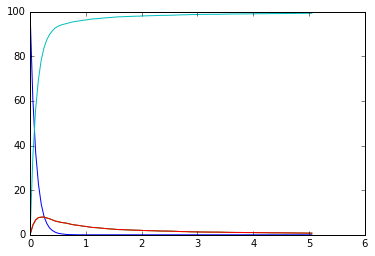

In [155]:
plt.plot(tspan,micro[0])

In [156]:
#solver._write_mesh_file("spheremesh.h5")
#solver.serialize("urdmeinputesphere.mat")

In [157]:
num_traj = 10
nspecies = 4

In [158]:
#model = Example2(1e-18)
#solver = microsolver.MMMSSolver(model)
#temp = solver.run()

In [159]:
pi = 3.14159265359

In [160]:
timem1 = time.time()

res = []
kr=[1.0,0.5,0.16,0.08,0.04,0.02,0.01]

mmms = []

for k in range(0,len(kr)):
    model = Example2(kr=kr[k])
    solver = microsolver.MMMSSolver(model)
    Sout = []
    for i in range(0,num_traj):
        temp = solver.run()
        if(i==0):
            for j in range(0,nspecies):
                Sout.append(temp.get_summary_statistic(j))
        else:
            for j in range(0,nspecies):
                Sout[j] = Sout[j]+temp.get_summary_statistic(j)
            
    for j in range(0,nspecies):
        Sout[j] = Sout[j]/num_traj
        
    mmms.append(Sout)
        
timem2 = time.time()
print timem2-timem1

2402.09564304


In [129]:
#model = Example2(kr=kr[1])

In [141]:
#params = model.get_all_parameters()
#print params
#kr_micro = 0.2
#model.set_parameter(pname='krm',expression=kr_micro)
#params['krm'].expression = 0.2
#params = model.get_all_parameters()


OrderedDict([('krm', <pyurdme.model.Parameter instance at 0x7f4466e50320>), ('kd', <pyurdme.model.Parameter instance at 0x7f4466e503f8>)])
0.2


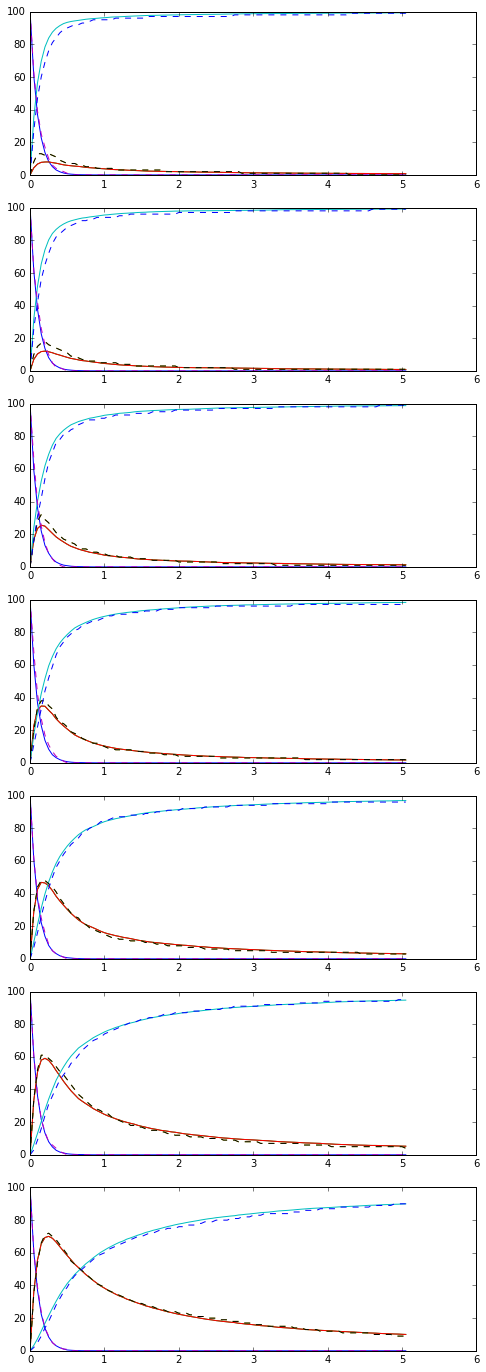

In [150]:
f, axs = plt.subplots(len(kr), 1,figsize=(8,24))
for i in range(0,len(kr)):
    axs[i].plot(tspan,micro[i])

for j in range(0,len(kr)):    
    for i in range(0,nspecies):
        axs[j].plot(tspan,mmms[j][i],linestyle='--')

In [151]:

err = []
for j in range(0,len(kr)):
    temp = 0.0
    temp2 = 0.0
    for i in range(0,nspecies):
        for k in range(0,21):
            temp = temp+abs(micro[j][k][i]-mmms[j][i][k])
            temp2 = temp2+abs(micro[j][k][i])
            
    err.append(temp/temp2)

In [152]:
err

[0.087066878635690292,
 0.085688760730444152,
 0.07621418843836944,
 0.057288194775100797,
 0.035070296229869034,
 0.054185500157995253,
 0.022708676879696892]

In [24]:
micro

[array([[  1.00000000e+02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  9.03700000e+01,   9.00000000e-02,   9.00000000e-02,
          9.54000000e+00],
       [  8.08700000e+01,   2.10000000e-01,   2.10000000e-01,
          1.89200000e+01],
       [  7.34300000e+01,   2.90000000e-01,   2.90000000e-01,
          2.62800000e+01],
       [  6.66400000e+01,   3.20000000e-01,   3.20000000e-01,
          3.30400000e+01],
       [  6.04000000e+01,   4.10000000e-01,   4.10000000e-01,
          3.91900000e+01],
       [  5.46700000e+01,   4.70000000e-01,   4.70000000e-01,
          4.48600000e+01],
       [  4.93400000e+01,   5.70000000e-01,   5.70000000e-01,
          5.00900000e+01],
       [  4.46700000e+01,   5.70000000e-01,   5.70000000e-01,
          5.47600000e+01],
       [  4.03700000e+01,   5.60000000e-01,   5.60000000e-01,
          5.90700000e+01],
       [  3.67500000e+01,   6.10000000e-01,   6.10000000e-01,
          6.26400000e+01],
       [  3.32000000

0

101

In [13]:
pos = temp.get_particles(0,0)
pos = pos['positions']


In [90]:

outpos = []
numtraj=50
for i in range(0,numtraj):
    out = solver.run()
    pos = out.get_particles(3,50)
    pos = pos['positions']
    outpos.append(pos)

In [91]:
r = []
for j in range(0,numtraj):
    temp = outpos[j]
    for i in range(0,len(temp)):
        r.append(norm(temp[i]))
    


1063


(array([   5.,   13.,   20.,   43.,   61.,   92.,  111.,  151.,  190.,  377.]),
 array([ 0.03395741,  0.09218694,  0.15041647,  0.20864601,  0.26687554,
        0.32510507,  0.3833346 ,  0.44156414,  0.49979367,  0.5580232 ,
        0.61625273]),
 <a list of 10 Patch objects>)

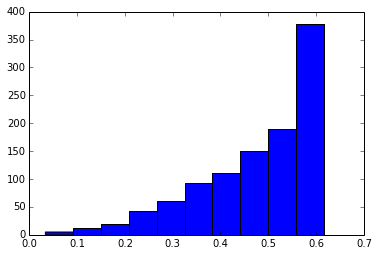

In [92]:
print len(r)
plt.hist(r)

In [93]:
out2 = model.run()

In [94]:
print out2

{'Status': 'Sucess', 'stdout': 'Ncells:3418 Mspecies: 4', 'tspan': None, 'sol': None, 'sol_initialized': False, 'filename': '/tmp/tmpoN4MCU', 'U': None, 'stderr': '', 'model': <__main__.Example2 instance at 0x7f5874618e60>, 'data_is_loaded': False}
